# CNN + ViT: Hybrid model (Keras way)

In [5]:
%%time
import warnings
warnings.filterwarnings('ignore')

import os
import time
import httpx
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datetime import datetime
def present_time():
        return datetime.now().strftime('%Y%m%d_%H%M%S')



CPU times: user 63.3 ms, sys: 3.86 ms, total: 67.2 ms
Wall time: 67.9 ms


In [6]:
%%time
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import HeUniform
from tensorflow.keras.callbacks import ModelCheckpoint

gpu_list = tf.config.list_physical_devices('GPU')
device = "gpu" if gpu_list != [] else "cpu"
print(f"Device available for training: {device}")

Device available for training: gpu
CPU times: user 5.43 s, sys: 814 ms, total: 6.25 s
Wall time: 7.06 s


## Model download helper

In [7]:
async def download_model(url, model_path):
    if not os.path.exists(model_path):
        try:
            print(f"Downloading from {url}...")
            import httpx
            async with httpx.AsyncClient() as client:
                response = await client.get(url, follow_redirects=True)
                response.raise_for_status()
                with open(model_path, "wb") as f:
                    f.write(response.content)
            print(f"Successfully downloaded '{model_path}'.")
        except Exception as e:
            print(f"Download error: {e}")
    else:
        print(f"Model file already downloaded at: {model_path}")

In [8]:
data_dir = "."

keras_model_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/U-uPeyCyOQYh0GrZPGsqoQ/ai-capstone-keras-best-model-model.keras"
keras_model_name = "ai-capstone-keras-best-model-model_downloaded.keras"
keras_model_path = os.path.join(data_dir, keras_model_name)

await download_model(keras_model_url, keras_model_path)

Successfully downloaded './ai-capstone-keras-best-model-model_downloaded.keras'.


In [9]:
# Set seed for reproducibility
seed_value = 7331
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Model loading and setup

In [ ]:
cnn_model = load_model(keras_model_path)

cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 32)     │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 256)      │       819,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 4, 4, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 512)      │     3,277,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 2, 2, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 2, 2, 1024)     │    13,108,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │             

 Total params: 61,034,501 (232.83 MB)

 Trainable params: 20,340,801 (77.59 MB)

 Non-trainable params: 12,096 (47.25 KB)

 Optimizer params: 40,681,604 (155.19 MB)

In [ ]:
feature_layer_name = "batch_normalization_5"

In [ ]:
@tf.keras.utils.register_keras_serializable(package="Custom")
class AddPositionEmbedding(layers.Layer):
    def __init__(self, num_patches, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.embed_dim   = embed_dim
        self.pos = self.add_weight(
            name="pos_embedding",
            shape=(1, num_patches, embed_dim),
            initializer="random_normal",
            trainable=True)

    def call(self, tokens):
        return tokens + self.pos

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_patches": self.num_patches,
            "embed_dim":   self.embed_dim,
        })
        return {**config}

In [ ]:
@tf.keras.utils.register_keras_serializable(package="Custom")
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads=8, mlp_dim=2048, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim   = mlp_dim
        self.dropout   = dropout
        self.mha  = layers.MultiHeadAttention(num_heads, key_dim=embed_dim)
        self.norm1 = layers.LayerNormalization(epsilon=1e-6)
        self.norm2 = layers.LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
            layers.Dense(mlp_dim, activation="gelu"),
            layers.Dropout(dropout),
            layers.Dense(embed_dim),
            layers.Dropout(dropout)
        ])

    def call(self, x):
        x = self.norm1(x + self.mha(x, x))
        return self.norm2(x + self.mlp(x))

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim":  self.embed_dim,
            "num_heads":  self.num_heads,
            "mlp_dim":    self.mlp_dim,
            "dropout":    self.dropout,
        })
        return {**config}


## Hybrid model builder function

In [14]:
def build_cnn_vit_hybrid(
        cnn_model,
        feature_layer_name,
        num_transformer_layers=4,
        num_heads=8,
        mlp_dim=2048,
        num_classes=2):
    # 1. Freeze or fine-tune the CNN as you prefer
    cnn_model.trainable = False      # set True to fine-tune

    # 2. Feature extractor up to the chosen layer
    features = cnn_model.get_layer(feature_layer_name).output
    H, W, C = features.shape[1], features.shape[2], features.shape[3]

    # 3. Flatten spatial grid → tokens  &  add positional encoding
    x = layers.Reshape((H * W, C))(features)
    x = AddPositionEmbedding(H * W, C)(x)

    # 4. Stack ViT encoder blocks
    for _ in range(num_transformer_layers):
        x = TransformerBlock(C, num_heads, mlp_dim)(x)

    # 5. Token pooling & classification head
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    return Model(cnn_model.layers[0].input, outputs, name="CNN_ViT_hybrid")


## Data augmentation & generation pipeline

In [15]:

dataset_path = os.path.join(data_dir, "images_dataSAT")
print(dataset_path)

img_w, img_h = 64, 64
n_channels = 3
batch_size = 4
num_classes = 2


datagen = ImageDataGenerator(rescale=1./255,
                             rotation_range=40,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.2,
                             zoom_range=0.2,
                             horizontal_flip=True,
                             fill_mode="nearest",
                             validation_split=0.2
                            )

train_gen = datagen.flow_from_directory(dataset_path,
                                        target_size = (img_w, img_h),
                                        batch_size= batch_size,
                                        class_mode="categorical",
                                        subset="training",
                                        shuffle=True
                                       )

val_gen = datagen.flow_from_directory(dataset_path,
                                      target_size =(img_w, img_h),
                                      batch_size = batch_size,
                                      class_mode="categorical",
                                      subset="validation",
                                      shuffle=True
                                     )


./images_dataSAT
Found 4800 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


## Model checkpoint setup

In [16]:
class CustomPrintCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        # Print epoch number and starting time
        print(f"Epoch {(epoch + 1):02d} completed on {present_time()}")
time_print_callback = CustomPrintCallback()

In [ ]:
model_name = "keras_cnn_vit.model.keras"

checkpoint_cb = ModelCheckpoint(
    filepath=model_name,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

## Model training and compilation

In [ ]:
num_classes = train_gen.num_classes
hybrid_model = build_cnn_vit_hybrid(
        cnn_model,
        feature_layer_name=feature_layer_name,
        num_transformer_layers=4,
        num_heads=8,
        mlp_dim=2048,
        num_classes=train_gen.num_classes)

In [ ]:
hybrid_model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [ ]:
fit = hybrid_model.fit(
    train_gen,
    epochs=3,
    validation_data=val_gen,
    callbacks=[checkpoint_cb],
    steps_per_epoch=128
)

Epoch 1/3
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9820 - loss: 0.3509
Epoch 1: val_loss improved from inf to 0.07213, saving model to keras_cnn_vit.model.keras
128/128 ━━━━━━━━━━━━━━━━━━━━ 67s 351ms/step - accuracy: 0.9820 - loss: 0.3490 - val_accuracy: 0.9883 - val_loss: 0.0721
Epoch 2/3
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9450 - loss: 0.4224
Epoch 2: val_loss did not improve from 0.07213
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9454 - loss: 0.4198 - val_accuracy: 0.9783 - val_loss: 0.1268
Epoch 3/3
127/128 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.9852 - loss: 0.0840
Epoch 3: val_loss did not improve from 0.07213
128/128 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.9852 - loss: 0.0839 - val_accuracy: 0.9858 - val_loss: 0.1359


## Training results visualization

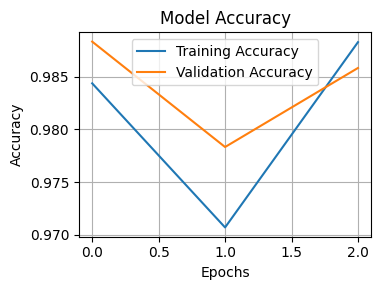

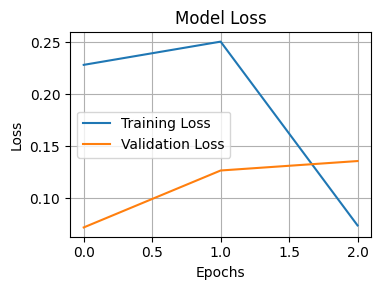

In [22]:
# Create a figure with a subplot
fig_w, fig_h = 4,3
fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Accuracy on the first subplot
axs.plot(fit.history['accuracy'], label='Training Accuracy')
axs.plot(fit.history['val_accuracy'], label='Validation Accuracy')
axs.set_title('Model Accuracy')
axs.set_xlabel('Epochs')
axs.set_ylabel('Accuracy')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()


## You can use this cell to type the code to complete the task.

fig, axs = plt.subplots(figsize=(fig_w, fig_h ))

# Plot Loss on the second subplot
axs.plot(fit.history['loss'], label='Training Loss')
axs.plot(fit.history['val_loss'], label='Validation Loss')
axs.set_title('Model Loss')
axs.set_xlabel('Epochs')
axs.set_ylabel('Loss')
axs.legend()
axs.grid(True)

plt.tight_layout()
plt.show()